# Step 1:Loading and Merging The dataset 

In [2]:
#Load the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from scipy.stats import shapiro
from sklearn.impute import SimpleImputer, KNNImputer


#Load the datasets

url1 ='https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data'
names = ["feature" + str(x) for x in range(1, 591)]
df1 = pd.read_csv(url1,sep=" ", names=names, na_values = "NaN",header=None)
df1.head()

url2 ='https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data'
df2 = pd.read_csv(url2,sep=" ",names = ["Result","Date"])
#df2.columns =['Pass/Fail','Date']
df2.head()



#Convertion of Date into Datetime from Object(String) data types
df2['Date'] = pd.to_datetime(df2['Date'])
df2.dtypes



#Joinig TWO df1 and df2 Dataframe naming SECOM
Secom = pd.concat([df1,df2],axis = 1)
print(Secom)



#We consider datetime donot have an important effect of whether a test fails or not.so dropping this column.
Secom = Secom.drop(['Date'],axis=1)
  
    
    
# establish target and features of the manufacturing data
# set the target to the encoded manufacturing outcome column

y = Secom[['Result']]



# set the features from sensors and putting in x 

x = Secom.drop(['Result'], axis=1)



# getting the shapes of new data sets x and y

print("shape of x:", x.shape)
print("shape of y:", y.shape)





      feature1  feature2   feature3   feature4  feature5  feature6  feature7  \
0      3030.93   2564.00  2187.7333  1411.1265    1.3602     100.0   97.6133   
1      3095.78   2465.14  2230.4222  1463.6606    0.8294     100.0  102.3433   
2      2932.61   2559.94  2186.4111  1698.0172    1.5102     100.0   95.4878   
3      2988.72   2479.90  2199.0333   909.7926    1.3204     100.0  104.2367   
4      3032.24   2502.87  2233.3667  1326.5200    1.5334     100.0  100.3967   
...        ...       ...        ...        ...       ...       ...       ...   
1562   2899.41   2464.36  2179.7333  3085.3781    1.4843     100.0   82.2467   
1563   3052.31   2522.55  2198.5667  1124.6595    0.8763     100.0   98.4689   
1564   2978.81   2379.78  2206.3000  1110.4967    0.8236     100.0   99.4122   
1565   2894.92   2532.01  2177.0333  1183.7287    1.5726     100.0   98.7978   
1566   2944.92   2450.76  2195.4444  2914.1792    1.5978     100.0   85.1011   

      feature8  feature9  feature10  ..

# Step 2: Splitting the dataset

In [3]:
#Splitting data
#Since according to dataset's description, target values are highly imbalanced, so we split it in a stratified fashion.

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 1,stratify = y)



# getting the counts

print("shape of x_train: ", x_train.shape)
print("shape of x_test: ", x_test.shape)
print("shape of y_train: ", y_train.shape)
print("shape of y_test: ", y_test.shape)






shape of x_train:  (1096, 590)
shape of x_test:  (471, 590)
shape of y_train:  (1096, 1)
shape of y_test:  (471, 1)


In [4]:
#REMOVING FEATURES HAVING MISSING VALUE RATIO MORE THAN 50%.

def percentna(dataframe, threshold):
    columns = dataframe.columns[(dataframe.isnull().sum()/len(dataframe))>threshold]
    return columns.tolist()
na_columns = percentna(x_train, 0.5)
len(na_columns)
x_train_dn = x_train.drop(na_columns, axis=1)
x_train_dn.shape







(1096, 566)

In [5]:
#REMOVING COLUMNS WITH UNIQUE VALUES(Low Variance)

from sklearn.feature_selection import VarianceThreshold
var_thres=VarianceThreshold(threshold=0)
var_thres.fit(x_train_dn)
constant_columns = [column for column in x_train_dn.columns
                    if column not in x_train_dn.columns[var_thres.get_support()]]
print(len(constant_columns))
x_train_lv = x_train_dn.drop(constant_columns,axis=1)







116


In [6]:
#Dropping the Columns in test dataset also .
#In order to match the shape of x_train and x_test for further analysis.

x_test_drop = x_test.copy()
x_test_drop = x_test_drop.drop(na_columns, axis=1)
x_test_drop = x_test_drop.drop(constant_columns,axis=1)



# Step4:Outlier Treatment

In [7]:
#OUTLIER IMPUTATION using 3s rule

def outliers(feat):
 upper_limit = feat.mean() + 3*feat.std()
 lower_limit = feat.mean() - 3*feat.std()

 feat = np.where(
    feat >upper_limit,
    upper_limit,
    np.where(
       feat <lower_limit,
        lower_limit,
        feat ))
 return feat

x_train_outliers_imputation =x_train_lv.copy()
for column in x_train_outliers_imputation:
  x_train_outliers_imputation[column] = outliers(x_train_outliers_imputation[column])


# Step5: Missing value imputation

##### Applying Gridsearch to find optimal parameter for Missing value imputaion using KNN Imputer

In [8]:
from sklearn.model_selection import GridSearchCV 
model_params = {
    'KNN': {
        'model': KNNImputer(),
        'params' : {
            'n_neighbors': list(range(1,30)),
            'weights' : ['uniform', 'distance'],
            'add_indicator': [True, False]
        }  
    }
}


scores = []
for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'] ,scoring="accuracy",cv=None ,return_train_score=False)
    clf.fit(x_train_outliers_imputation, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
        'best_estimator':clf.best_estimator_,
    })
    
gridsearch = pd.DataFrame(scores,columns=['model','best_score','best_params','best_estimator'])
gridsearch


,model,best_score,best_params,best_estimator
0,KNN,NaN,"{'add_indicator': True, 'n_neighbors': 1, 'wei...","KNNImputer(add_indicator=True, n_neighbors=1)"


In [9]:
#Using KNN Imputation Method

numColumns = x_train_outliers_imputation.select_dtypes(include=np.number).columns.tolist();
# initialize imputer
imputer = KNNImputer(n_neighbors = 1,weights='uniform')
# fit the imputer on X_train. pass only numeric columns.
imputer.fit(x_train_outliers_imputation[numColumns])
# transform the data using the fitted imputer
X_train_knn_impute1 = imputer.transform(x_train_outliers_imputation[numColumns])
X_test_knn_impute1 = imputer.transform(x_test[numColumns])
# put the output into DataFrame. remember to pass columns used in fit/transform
X_train_knn_impute1 = pd.DataFrame(X_train_knn_impute1, columns=numColumns)
X_test_knn_impute1 = pd.DataFrame(X_test_knn_impute1, columns=numColumns)

# Step6: Feature Selection

In [10]:
!pip install boruta
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=1, n_estimators=1000, max_depth=5)
boruta_selector = BorutaPy(rfc, n_estimators='auto', verbose=2, random_state=1)
boruta_selector.fit(np.array(X_train_knn_impute1), np.array(y_train)) 

# Ranking of Boruta

print("Ranking: ",boruta_selector.ranking_)          
print("No. of significant features: ", boruta_selector.n_features_) 

selected_rf_features = pd.DataFrame({'Feature':list(X_train_knn_impute1.columns),
                                       'Ranking':boruta_selector.ranking_})
selected_rf_features.sort_values(by='Ranking').head(30)

# Using the BorutaPy object to transform the features in the dataset.

accepted = X_train_knn_impute1.columns[boruta_selector.support_].to_list()

undecided = X_train_knn_impute1.columns[boruta_selector.support_weak_].to_list()

selected_features = accepted + undecided

X_Filtered_train = X_train_knn_impute1[selected_features]
X_Filtered_test =  X_test_knn_impute1[selected_features]


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 56 kB 3.6 MB/s 
Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	450
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	450
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	450
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	450
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	450
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	450
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	450
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	435
Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	435
Iteration: 	10 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	435
Iteration: 	11 / 100
Confirmed: 	0
Tentative: 	15
Rejected: 	435
Iteration: 	12 / 100
Confirmed: 	3
Tentative: 	12
Rejected: 	435
Iteration: 	13 / 100
Confirmed: 	3
Tentative: 	12
Rejected: 	435
Iteration: 	14 /

#### Checking the results Using classifier before hyperparameter tuning & handling imbalance

In [11]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
#from sklearn.metrics import scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV

classifiers = [['Naive Bayes :', GaussianNB()],
               ['KNeighbours :', KNeighborsClassifier()],
               ['SVM :', SVC()],
               ['LogisticRegression :', LogisticRegression()],
               ['DecisionTree :',DecisionTreeClassifier()],
               ['RandomForest :',RandomForestClassifier()]]

for name,classifier in classifiers:
    clf=classifier.fit(X_Filtered_train,y_train)
    y_pred=classifier.predict(X_Filtered_test)
    print(f'\n {name} \n')
    print(f'Training Score for {name}  {clf.score(X_Filtered_train,y_train) * 100:.2f}' )
    print(f'Testing Score for {name} {clf.score(X_Filtered_test,y_test) * 100:.2f}' )
    print(f'Classification report  \n {classification_report(y_test,y_pred)}' )
    print(f'Confusion matrix  \n {confusion_matrix(y_test,y_pred)}' )
    print(f'ROC AUC  : {roc_auc_score(y_test,y_pred)}' )


 Naive Bayes : 

Training Score for Naive Bayes :  90.24
Testing Score for Naive Bayes : 89.17
Classification report  
               precision    recall  f1-score   support

          -1       0.95      0.93      0.94       440
           1       0.24      0.29      0.26        31

    accuracy                           0.89       471
   macro avg       0.59      0.61      0.60       471
weighted avg       0.90      0.89      0.90       471

Confusion matrix  
 [[411  29]
 [ 22   9]]
ROC AUC  : 0.6122067448680352

 KNeighbours : 

Training Score for KNeighbours :  93.34
Testing Score for KNeighbours : 92.78
Classification report  
               precision    recall  f1-score   support

          -1       0.94      0.99      0.96       440
           1       0.20      0.03      0.06        31

    accuracy                           0.93       471
   macro avg       0.57      0.51      0.51       471
weighted avg       0.89      0.93      0.90       471

Confusion matrix  
 [[436   4]


#### find best model among all the classification algorithm using GridSearchCV

In [12]:
from sklearn import svm
model_params = {
   'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [10,20],
            'gamma': [1.0],
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [69,60],
            'criterion' : ['entropy'],
            'max_depth': [24],
            'min_samples_split': [3],
            'max_samples' : [98]
        }
    },
     
    'Naive Bayes' : {
            'model': GaussianNB(),
            'params' : {
                'var_smoothing': np.logspace(0,-9, num=10000)}
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto',max_iter=600),
        'params': {
           'C': [2,3],
           'penalty':["l2"]
        }
    }
}

In [13]:
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=2, return_train_score=False)
    clf.fit(X_Filtered_train,y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df1 = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df1

,model,best_score,best_params
0,svm,0.933394,"{'C': 10, 'gamma': 1.0, 'kernel': 'rbf'}"
1,random_forest,0.933394,"{'criterion': 'entropy', 'max_depth': 24, 'max..."
2,Naive Bayes,0.930657,{'var_smoothing': 1.0}
3,logistic_regression,0.932482,"{'C': 2, 'penalty': 'l2'}"


##### The above the Best score and Best Parameters as stated by Grid search for Unbalanced dataset . We will balance the data and check the optimum balance method and best model for secom in the next steps

# Step7: Handling Imbalance

##### Applying Gridsearch to find optimal parameter for Imbalance Methods 

In [14]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import RandomOverSampler
model_params = {
    'SMOTE': {
        'model': SMOTE(),
        'params' : {
            'k_neighbors': list(range(1,30)),
            'random_state': [20,42,44]
        }  
    },
    'ROSE': {
        'model': RandomOverSampler(),
        'params' : {
            
            'random_state': [20,42,44]
        }  
    },
    'ADAYSN': {
        'model': ADASYN(),
        'params' : {
            'n_neighbors': list(range(1,30)),
            'random_state': [20,41,40,44]
        }  
    }
}



scores = []
for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'] ,scoring="accuracy",cv=None ,return_train_score=False)
    clf.fit(X_train_knn_impute1, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
        'best_estimator':clf.best_estimator_,
    })
    
gridsearch_SM = pd.DataFrame(scores,columns=['model','best_params','best_estimator'])
gridsearch_SM

,model,best_params,best_estimator
0,SMOTE,"{'k_neighbors': 1, 'random_state': 20}","SMOTE(k_neighbors=1, random_state=20)"
1,ROSE,{'random_state': 20},RandomOverSampler(random_state=20)
2,ADAYSN,"{'n_neighbors': 1, 'random_state': 20}","ADASYN(n_neighbors=1, random_state=20)"


### Balancing Method: SMOTE

In [15]:
#pip install imblearn
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

In [16]:
y_test.value_counts(normalize=True)

Result
-1        0.934183
 1        0.065817
dtype: float64

In [17]:
y_train.value_counts(normalize=True)

Result
-1        0.933394
 1        0.066606
dtype: float64

In [18]:
oversmote = SMOTE(k_neighbors=1, random_state=20)
X_train_sm, y_train_sm= oversmote.fit_resample(X_Filtered_train, y_train)

##### Applying Gridsearch to find optimal parameter for Classifier algorithms

In [19]:
 model_params = {
       
    
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [10,20],
            'gamma': [1.0],
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [69,60],
            'criterion' : ['entropy'],
            'max_depth': [24],
            'min_samples_split': [3],
            'max_samples' : [98]
        }
    },
     
    'Naive Bayes' : {
            'model': GaussianNB(),
            'params' : {
                'var_smoothing': np.logspace(0,-9, num=10000)}
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto',max_iter=600),
        'params': {
           'C': [2,3],
           'penalty':["l2"]
        }
    }
}
    
    
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=2, return_train_score=False)
    clf.fit(X_train_sm,y_train_sm)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,    
        'best_params': clf.best_params_,
        'best_estimator':clf.best_estimator_,
    })
    
df2 = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df2

,model,best_score,best_params
0,svm,0.960899,"{'C': 10, 'gamma': 1.0, 'kernel': 'rbf'}"
1,random_forest,0.842620,"{'criterion': 'entropy', 'max_depth': 24, 'max..."
2,Naive Bayes,0.686706,{'var_smoothing': 0.9554281212853747}
3,logistic_regression,0.692082,"{'C': 3, 'penalty': 'l2'}"


# Step8: Feature Scaling¶

In [20]:
col_name = list(X_Filtered_train.columns)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_minmax = scaler.fit_transform(X_train_sm)

X_test_minmax =scaler.transform(X_Filtered_test)

X_train_minmax = pd.DataFrame(X_train_minmax, columns=col_name)
X_test_minmax = pd.DataFrame(X_test_minmax, columns=col_name)

##### Classifiers which donot requires Feature scaling

In [21]:
#Algorithm

classifiers = [['Naive Bayes :', GaussianNB(var_smoothing = 0.688626606230121)],
                ['RandomForest :',RandomForestClassifier(n_estimators=69,criterion='entropy',max_depth=24,min_samples_split=3,max_samples=98)]]

for name,classifier in classifiers:
    clf=classifier.fit(X_train_sm,y_train_sm)
    y_pred=classifier.predict(X_Filtered_test)
    print(f'\n {name} \n')
    print(f'Training Score for {name}  {clf.score(X_train_sm,y_train_sm) * 100:.2f}' )
    print(f'Testing Score for {name} {clf.score(X_Filtered_test,y_test) * 100:.2f}' )
    print(f'Classification report  \n {classification_report(y_test,y_pred)}' )
    print(f'Confusion matrix  \n {confusion_matrix(y_test,y_pred)}' )
    print(f'ROC AUC  : {roc_auc_score(y_test,y_pred)}' )
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
    print('sensitivity is %f',1.*tp/(tp+fn))
    print('specificity is %f',1.*tn/(tn+fp))
    print('accuracy is %f',1.*(tp+tn)/(tp+tn+fp+fn))
    print('balanced accuracy is %',1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp)))
    print('Type1 Error is %f',1.*(fp))
    print('Type2 Error is %f',1.*(fn))
 
    
    
    
   
   


 Naive Bayes : 

Training Score for Naive Bayes :  68.57
Testing Score for Naive Bayes : 84.50
Classification report  
               precision    recall  f1-score   support

          -1       0.96      0.87      0.91       440
           1       0.22      0.52      0.30        31

    accuracy                           0.85       471
   macro avg       0.59      0.69      0.61       471
weighted avg       0.91      0.85      0.87       471

Confusion matrix  
 [[382  58]
 [ 15  16]]
ROC AUC  : 0.6921554252199413
sensitivity is %f 0.5161290322580645
specificity is %f 0.8681818181818182
accuracy is %f 0.8450106157112527
balanced accuracy is % 0.6921554252199413
Type1 Error is %f 58.0
Type2 Error is %f 15.0

 RandomForest : 

Training Score for RandomForest :  88.07
Testing Score for RandomForest : 77.92
Classification report  
               precision    recall  f1-score   support

          -1       0.95      0.80      0.87       440
           1       0.14      0.45      0.21       

##### Classifiers which requires Feature scaling

In [22]:
classifiers = [['SVM :', SVC(C=10.0, gamma=1.0, kernel='linear')],
               ['LogisticRegression :', LogisticRegression(penalty='l2',C=2,solver='liblinear',max_iter=600)]]

for name,classifier in classifiers:
    clf=classifier.fit(X_train_minmax,y_train_sm)
    y_pred=classifier.predict(X_test_minmax)
    print(f'\n {name} \n')
    print(f'Training Score for {name}  {clf.score(X_train_minmax,y_train_sm) * 100:.2f}' )
    print(f'Testing Score for {name} {clf.score(X_test_minmax,y_test) * 100:.2f}' )
    print(f'Classification report  \n {classification_report(y_test,y_pred)}' )
    print(f'Confusion matrix  \n {confusion_matrix(y_test,y_pred)}' )
    print(f'ROC AUC  : {roc_auc_score(y_test,y_pred)}' )
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
    print('sensitivity is %f',1.*tp/(tp+fn))
    print('specificity is %f',1.*tn/(tn+fp))
    print('accuracy is %f',1.*(tp+tn)/(tp+tn+fp+fn))
    print('balanced accuracy is %',1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp)))
    print('Type1 Error is %f',1.*(fp))
    print('Type2 Error is %f',1.*(fn))
 


 SVM : 

Training Score for SVM :  67.60
Testing Score for SVM : 85.14
Classification report  
               precision    recall  f1-score   support

          -1       0.96      0.88      0.92       440
           1       0.23      0.52      0.31        31

    accuracy                           0.85       471
   macro avg       0.59      0.70      0.62       471
weighted avg       0.91      0.85      0.88       471

Confusion matrix  
 [[385  55]
 [ 15  16]]
ROC AUC  : 0.6955645161290323
sensitivity is %f 0.5161290322580645
specificity is %f 0.875
accuracy is %f 0.851380042462845
balanced accuracy is % 0.6955645161290323
Type1 Error is %f 55.0
Type2 Error is %f 15.0

 LogisticRegression : 

Training Score for LogisticRegression :  69.11
Testing Score for LogisticRegression : 81.53
Classification report  
               precision    recall  f1-score   support

          -1       0.96      0.83      0.89       440
           1       0.19      0.55      0.28        31

    accuracy   

### Balancing Method: ROSE

In [23]:
rose = RandomOverSampler(random_state=20)
X_train_rs, y_train_rs= rose.fit_resample(X_Filtered_train, y_train)

In [24]:
# Feature scaling after ROSE

scaler = MinMaxScaler()

X_train_minmax_rs = scaler.fit_transform(X_train_rs)

X_test_minmax_rs =scaler.transform(X_Filtered_test)

X_train_minmax_rs = pd.DataFrame(X_train_minmax_rs, columns=col_name)
X_test_minmax_rs = pd.DataFrame(X_test_minmax_rs, columns=col_name)

In [25]:
 model_params = {
       
    
     'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [10,20],
            'gamma': [1.0],
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [69,60],
            'criterion' : ['entropy'],
            'max_depth': [24],
            'min_samples_split': [3],
            'max_samples' : [98]
        }
    },
     
    'Naive Bayes' : {
            'model': GaussianNB(),
            'params' : {
                'var_smoothing': np.logspace(0,-9, num=10000)}
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto',max_iter=600),
        'params': {
           'C': [2,3],
           'penalty':["l2"]
        }
    }
}
    
    
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=2, return_train_score=False)
    clf.fit(X_train_rs,y_train_rs)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,    
        'best_params': clf.best_params_,
        'best_estimator':clf.best_estimator_,
    })
    
df3 = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df3

,model,best_score,best_params
0,svm,1.000000,"{'C': 10, 'gamma': 1.0, 'kernel': 'rbf'}"
1,random_forest,0.878788,"{'criterion': 'entropy', 'max_depth': 24, 'max..."
2,Naive Bayes,0.691105,{'var_smoothing': 2.9932818669066775e-08}
3,logistic_regression,0.695015,"{'C': 2, 'penalty': 'l2'}"


##### Classifiers which donot requires Feature scaling

In [26]:
#Algorithm

classifiers = [['Naive Bayes :', GaussianNB(var_smoothing = 0.688626606230121)],
               ['RandomForest :',RandomForestClassifier(n_estimators=69,criterion='entropy',max_depth=24,min_samples_split=3,max_samples=98)]]

for name,classifier in classifiers:
    clf=classifier.fit(X_train_rs,y_train_rs)
    y_pred=classifier.predict(X_Filtered_test)
    print(f'\n {name} \n')
    print(f'Training Score for {name}  {clf.score(X_train_rs,y_train_rs) * 100:.2f}' )
    print(f'Testing Score for {name} {clf.score(X_Filtered_test,y_test) * 100:.2f}' )
    print(f'Classification report  \n {classification_report(y_test,y_pred)}' )
    print(f'Confusion matrix  \n {confusion_matrix(y_test,y_pred)}' )
    print(f'ROC AUC  : {roc_auc_score(y_test,y_pred)}' )
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
    print('sensitivity is %f',1.*tp/(tp+fn))
    print('specificity is %f',1.*tn/(tn+fp))
    print('accuracy is %f',1.*(tp+tn)/(tp+tn+fp+fn))
    print('balanced accuracy is %',1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp)))
    print('Type1 Error is %f',1.*(fp))
    print('Type2 Error is %f',1.*(fn))
 
    
    
    
   
   


 Naive Bayes : 

Training Score for Naive Bayes :  66.81
Testing Score for Naive Bayes : 85.35
Classification report  
               precision    recall  f1-score   support

          -1       0.96      0.88      0.92       440
           1       0.22      0.48      0.30        31

    accuracy                           0.85       471
   macro avg       0.59      0.68      0.61       471
weighted avg       0.91      0.85      0.88       471

Confusion matrix  
 [[387  53]
 [ 16  15]]
ROC AUC  : 0.6817082111436951
sensitivity is %f 0.4838709677419355
specificity is %f 0.8795454545454545
accuracy is %f 0.8535031847133758
balanced accuracy is % 0.681708211143695
Type1 Error is %f 53.0
Type2 Error is %f 16.0

 RandomForest : 

Training Score for RandomForest :  91.40
Testing Score for RandomForest : 77.71
Classification report  
               precision    recall  f1-score   support

          -1       0.97      0.79      0.87       440
           1       0.17      0.61      0.27        

##### Classifiers which requires Feature scaling

In [27]:
classifiers = [['SVM :', SVC(C=10.0, gamma=1.0, kernel='linear')],
               ['LogisticRegression :', LogisticRegression(penalty='l2',C=2,solver='liblinear',max_iter=600)]]

for name,classifier in classifiers:
    clf=classifier.fit(X_train_minmax_rs ,y_train_rs)
    y_pred=classifier.predict(X_test_minmax_rs)
    print(f'\n {name} \n')
    print(f'Training Score for {name}  {clf.score(X_train_minmax_rs,y_train_rs) * 100:.2f}' )
    print(f'Testing Score for {name} {clf.score(X_test_minmax_rs,y_test) * 100:.2f}' )
    print(f'Classification report  \n {classification_report(y_test,y_pred)}' )
    print(f'Confusion matrix  \n {confusion_matrix(y_test,y_pred)}' )
    print(f'ROC AUC  : {roc_auc_score(y_test,y_pred)}' )
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
    print('sensitivity is %f',1.*tp/(tp+fn))
    print('specificity is %f',1.*tn/(tn+fp))
    print('accuracy is %f',1.*(tp+tn)/(tp+tn+fp+fn))
    print('balanced accuracy is %',1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp)))
    print('Type1 Error is %f',1.*(fp))
    print('Type2 Error is %f',1.*(fn))
 


 SVM : 

Training Score for SVM :  67.60
Testing Score for SVM : 85.35
Classification report  
               precision    recall  f1-score   support

          -1       0.96      0.88      0.92       440
           1       0.23      0.52      0.32        31

    accuracy                           0.85       471
   macro avg       0.60      0.70      0.62       471
weighted avg       0.91      0.85      0.88       471

Confusion matrix  
 [[386  54]
 [ 15  16]]
ROC AUC  : 0.6967008797653959
sensitivity is %f 0.5161290322580645
specificity is %f 0.8772727272727273
accuracy is %f 0.8535031847133758
balanced accuracy is % 0.696700879765396
Type1 Error is %f 54.0
Type2 Error is %f 15.0

 LogisticRegression : 

Training Score for LogisticRegression :  69.31
Testing Score for LogisticRegression : 81.74
Classification report  
               precision    recall  f1-score   support

          -1       0.96      0.84      0.90       440
           1       0.19      0.55      0.28        31

  

### Balancing Method: ADASYN

In [28]:
adasyn = ADASYN(n_neighbors=1, random_state=20)
X_train_ad, y_train_ad= adasyn.fit_resample(X_Filtered_train, y_train)

In [29]:
# Feature scaling after ADASYN

scaler = MinMaxScaler()

X_train_minmax_ad = scaler.fit_transform(X_train_ad)

X_test_minmax_ad =scaler.transform(X_Filtered_test)

X_train_minmax_ad = pd.DataFrame(X_train_minmax_ad, columns=col_name)
X_test_minmax_ad = pd.DataFrame(X_test_minmax_ad, columns=col_name)

In [30]:
 model_params = {
       
    
    'svm': {
        'model': svm.SVC(),
        'params' : {
            'C': [10,20],
            'gamma': [1.0],
            'kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [69,60],
            'criterion' : ['entropy'],
            'max_depth': [24],
            'min_samples_split': [3],
            'max_samples' : [98]
        }
    },
     
    'Naive Bayes' : {
            'model': GaussianNB(),
            'params' : {
                'var_smoothing': np.logspace(0,-9, num=10000)}
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto',max_iter=600),
        'params': {
           'C': [2,3],
           'penalty':["l2"]
        }
    }
}
    
    
scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=2, return_train_score=False)
    clf.fit(X_train_ad,y_train_ad)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,    
        'best_params': clf.best_params_,
        'best_estimator':clf.best_estimator_,
    })
    
df4 = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df4

,model,best_score,best_params
0,svm,0.763893,"{'C': 10, 'gamma': 1.0, 'kernel': 'rbf'}"
1,random_forest,0.770171,"{'criterion': 'entropy', 'max_depth': 24, 'max..."
2,Naive Bayes,0.667332,{'var_smoothing': 0.688626606230121}
3,logistic_regression,0.667810,"{'C': 2, 'penalty': 'l2'}"


###### Classifiers which donot requires Feature scaling

In [31]:
#Algorithm

classifiers = [['Naive Bayes :', GaussianNB(var_smoothing = 0.688626606230121)],
               ['RandomForest :',RandomForestClassifier(n_estimators=69,criterion='entropy',max_depth=24,min_samples_split=3,max_samples=98)]]

for name,classifier in classifiers:
    clf=classifier.fit(X_train_ad,y_train_ad)
    y_pred=classifier.predict(X_Filtered_test)
    print(f'\n {name} \n')
    print(f'Training Score for {name}  {clf.score(X_train_ad,y_train_ad) * 100:.2f}' )
    print(f'Testing Score for {name} {clf.score(X_Filtered_test,y_test) * 100:.2f}' )
    print(f'Classification report  \n {classification_report(y_test,y_pred)}' )
    print(f'Confusion matrix  \n {confusion_matrix(y_test,y_pred)}' )
    print(f'ROC AUC  : {roc_auc_score(y_test,y_pred)}' )
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
    print('sensitivity is %f',1.*tp/(tp+fn))
    print('specificity is %f',1.*tn/(tn+fp))
    print('accuracy is %f',1.*(tp+tn)/(tp+tn+fp+fn))
    print('balanced accuracy is %',1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp)))
    print('Type1 Error is %f',1.*(fp))
    print('Type2 Error is %f',1.*(fn))
 
    
    
    
   
   


 Naive Bayes : 

Training Score for Naive Bayes :  66.73
Testing Score for Naive Bayes : 84.71
Classification report  
               precision    recall  f1-score   support

          -1       0.96      0.87      0.91       440
           1       0.22      0.52      0.31        31

    accuracy                           0.85       471
   macro avg       0.59      0.69      0.61       471
weighted avg       0.91      0.85      0.87       471

Confusion matrix  
 [[383  57]
 [ 15  16]]
ROC AUC  : 0.693291788856305
sensitivity is %f 0.5161290322580645
specificity is %f 0.8704545454545455
accuracy is %f 0.8471337579617835
balanced accuracy is % 0.693291788856305
Type1 Error is %f 57.0
Type2 Error is %f 15.0

 RandomForest : 

Training Score for RandomForest :  88.03
Testing Score for RandomForest : 77.49
Classification report  
               precision    recall  f1-score   support

          -1       0.95      0.80      0.87       440
           1       0.12      0.39      0.18        3

##### Classifiers which requires Feature scaling

In [32]:

classifiers = [['SVM :', SVC(C=10.0, gamma=1.0, kernel='linear')],
               ['LogisticRegression :', LogisticRegression(penalty='l2',C=2,solver='liblinear',max_iter=600)]]

for name,classifier in classifiers:
    clf=classifier.fit(X_train_minmax_ad,y_train_ad)
    y_pred=classifier.predict(X_test_minmax_ad)
    print(f'\n {name} \n')
    print(f'Training Score for {name}  {clf.score(X_train_minmax_ad,y_train_ad) * 100:.2f}' )
    print(f'Testing Score for {name} {clf.score(X_test_minmax_ad,y_test) * 100:.2f}' )
    print(f'Classification report  \n {classification_report(y_test,y_pred)}' )
    print(f'Confusion matrix  \n {confusion_matrix(y_test,y_pred)}' )
    print(f'ROC AUC  : {roc_auc_score(y_test,y_pred)}' )
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
    print('sensitivity is %f',1.*tp/(tp+fn))
    print('specificity is %f',1.*tn/(tn+fp))
    print('accuracy is %f',1.*(tp+tn)/(tp+tn+fp+fn))
    print('balanced accuracy is %',1./2*(1.*tp/(tp+fn)+1.*tn/(tn+fp)))
    print('Type1 Error is %f',1.*(fp))
    print('Type2 Error is %f',1.*(fn))
 


 SVM : 

Training Score for SVM :  65.52
Testing Score for SVM : 85.14
Classification report  
               precision    recall  f1-score   support

          -1       0.96      0.88      0.92       440
           1       0.23      0.52      0.31        31

    accuracy                           0.85       471
   macro avg       0.59      0.70      0.62       471
weighted avg       0.91      0.85      0.88       471

Confusion matrix  
 [[385  55]
 [ 15  16]]
ROC AUC  : 0.6955645161290323
sensitivity is %f 0.5161290322580645
specificity is %f 0.875
accuracy is %f 0.851380042462845
balanced accuracy is % 0.6955645161290323
Type1 Error is %f 55.0
Type2 Error is %f 15.0

 LogisticRegression : 

Training Score for LogisticRegression :  69.05
Testing Score for LogisticRegression : 78.13
Classification report  
               precision    recall  f1-score   support

          -1       0.96      0.80      0.87       440
           1       0.17      0.58      0.26        31

    accuracy   

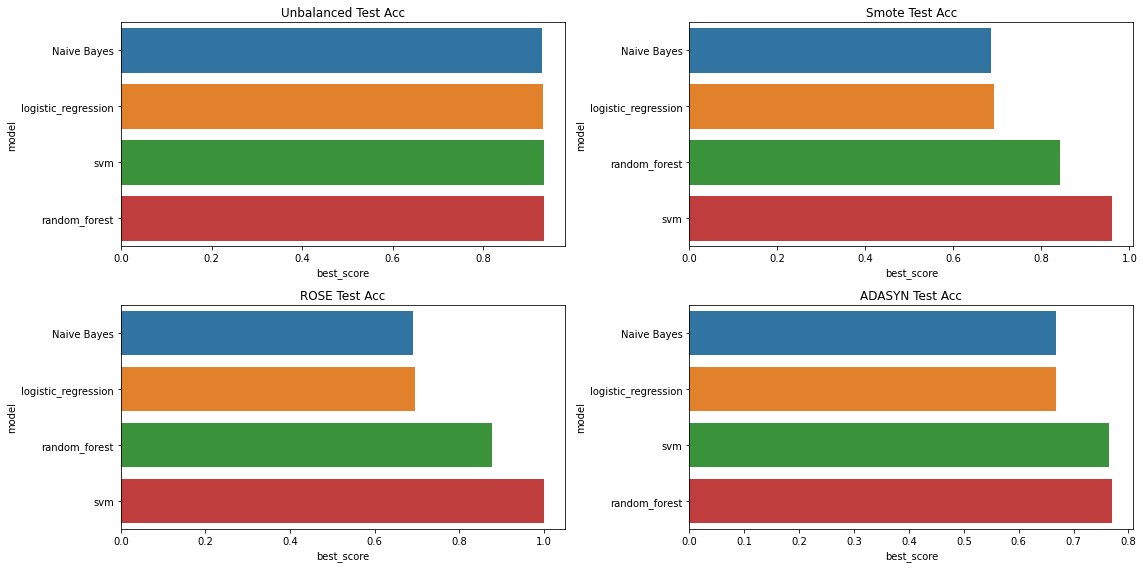

In [33]:
fig, ax = plt.subplots(2,2, figsize=(16, 8))
sns.barplot(x="best_score", y="model", data=df1.sort_values(by="best_score"), ax=ax[0,0])
ax[0,0].set_title("Unbalanced Test Acc")
sns.barplot(x="best_score", y="model", data=df2.sort_values(by="best_score"), ax=ax[0,1])
ax[0,1].set_title("Smote Test Acc")
sns.barplot(x="best_score", y="model", data=df3.sort_values(by="best_score"), ax=ax[1,0])
ax[1,0].set_title("ROSE Test Acc")
sns.barplot(x="best_score", y="model", data=df4.sort_values(by="best_score"), ax=ax[1,1])
ax[1,1].set_title("ADASYN Test Acc")



plt.tight_layout()
plt.show()

# Step9 :Model Assessment

# Step9: Final Data Modelling

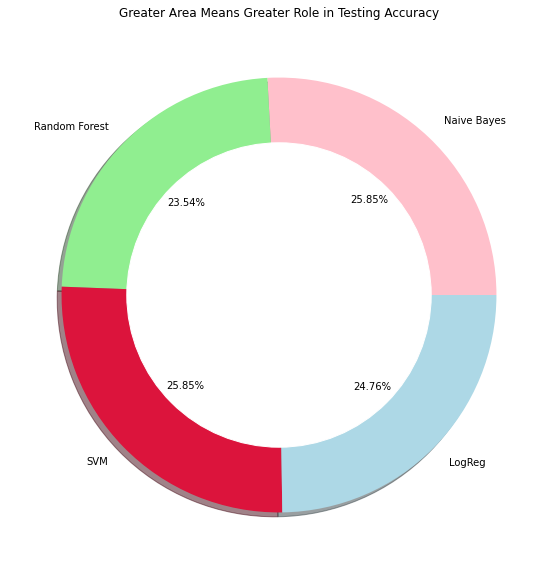

In [45]:
# defining the parameters for a pie chart

labels = "Naive Bayes","Random Forest", "SVM", "LogReg" 
size = [85.35, 77.71, 85.35, 81.74]
colors = ['pink',  'lightgreen', 'crimson','lightblue' ]

# Create a circle for the center of the plot
my_circle = plt.Circle( (0,0), 0.7, color = 'white')

plt.rcParams['figure.figsize'] = (10, 10)
plt.pie(size, colors = colors, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Greater Area Means Greater Role in Testing Accuracy')
p = plt.gcf()
p.gca().add_artist(my_circle)
#plt.legend()
plt.show()

# Step10: Model Evaluation